In [1]:
import numpy as np
from scipy import optimize as sp_optimize

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
p = 500
k = 4
sparsity = 0.4
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity)
sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
dj = np.ones(p)

In [4]:
sk

array([  0.1,   1. ,  10. , 100. ])

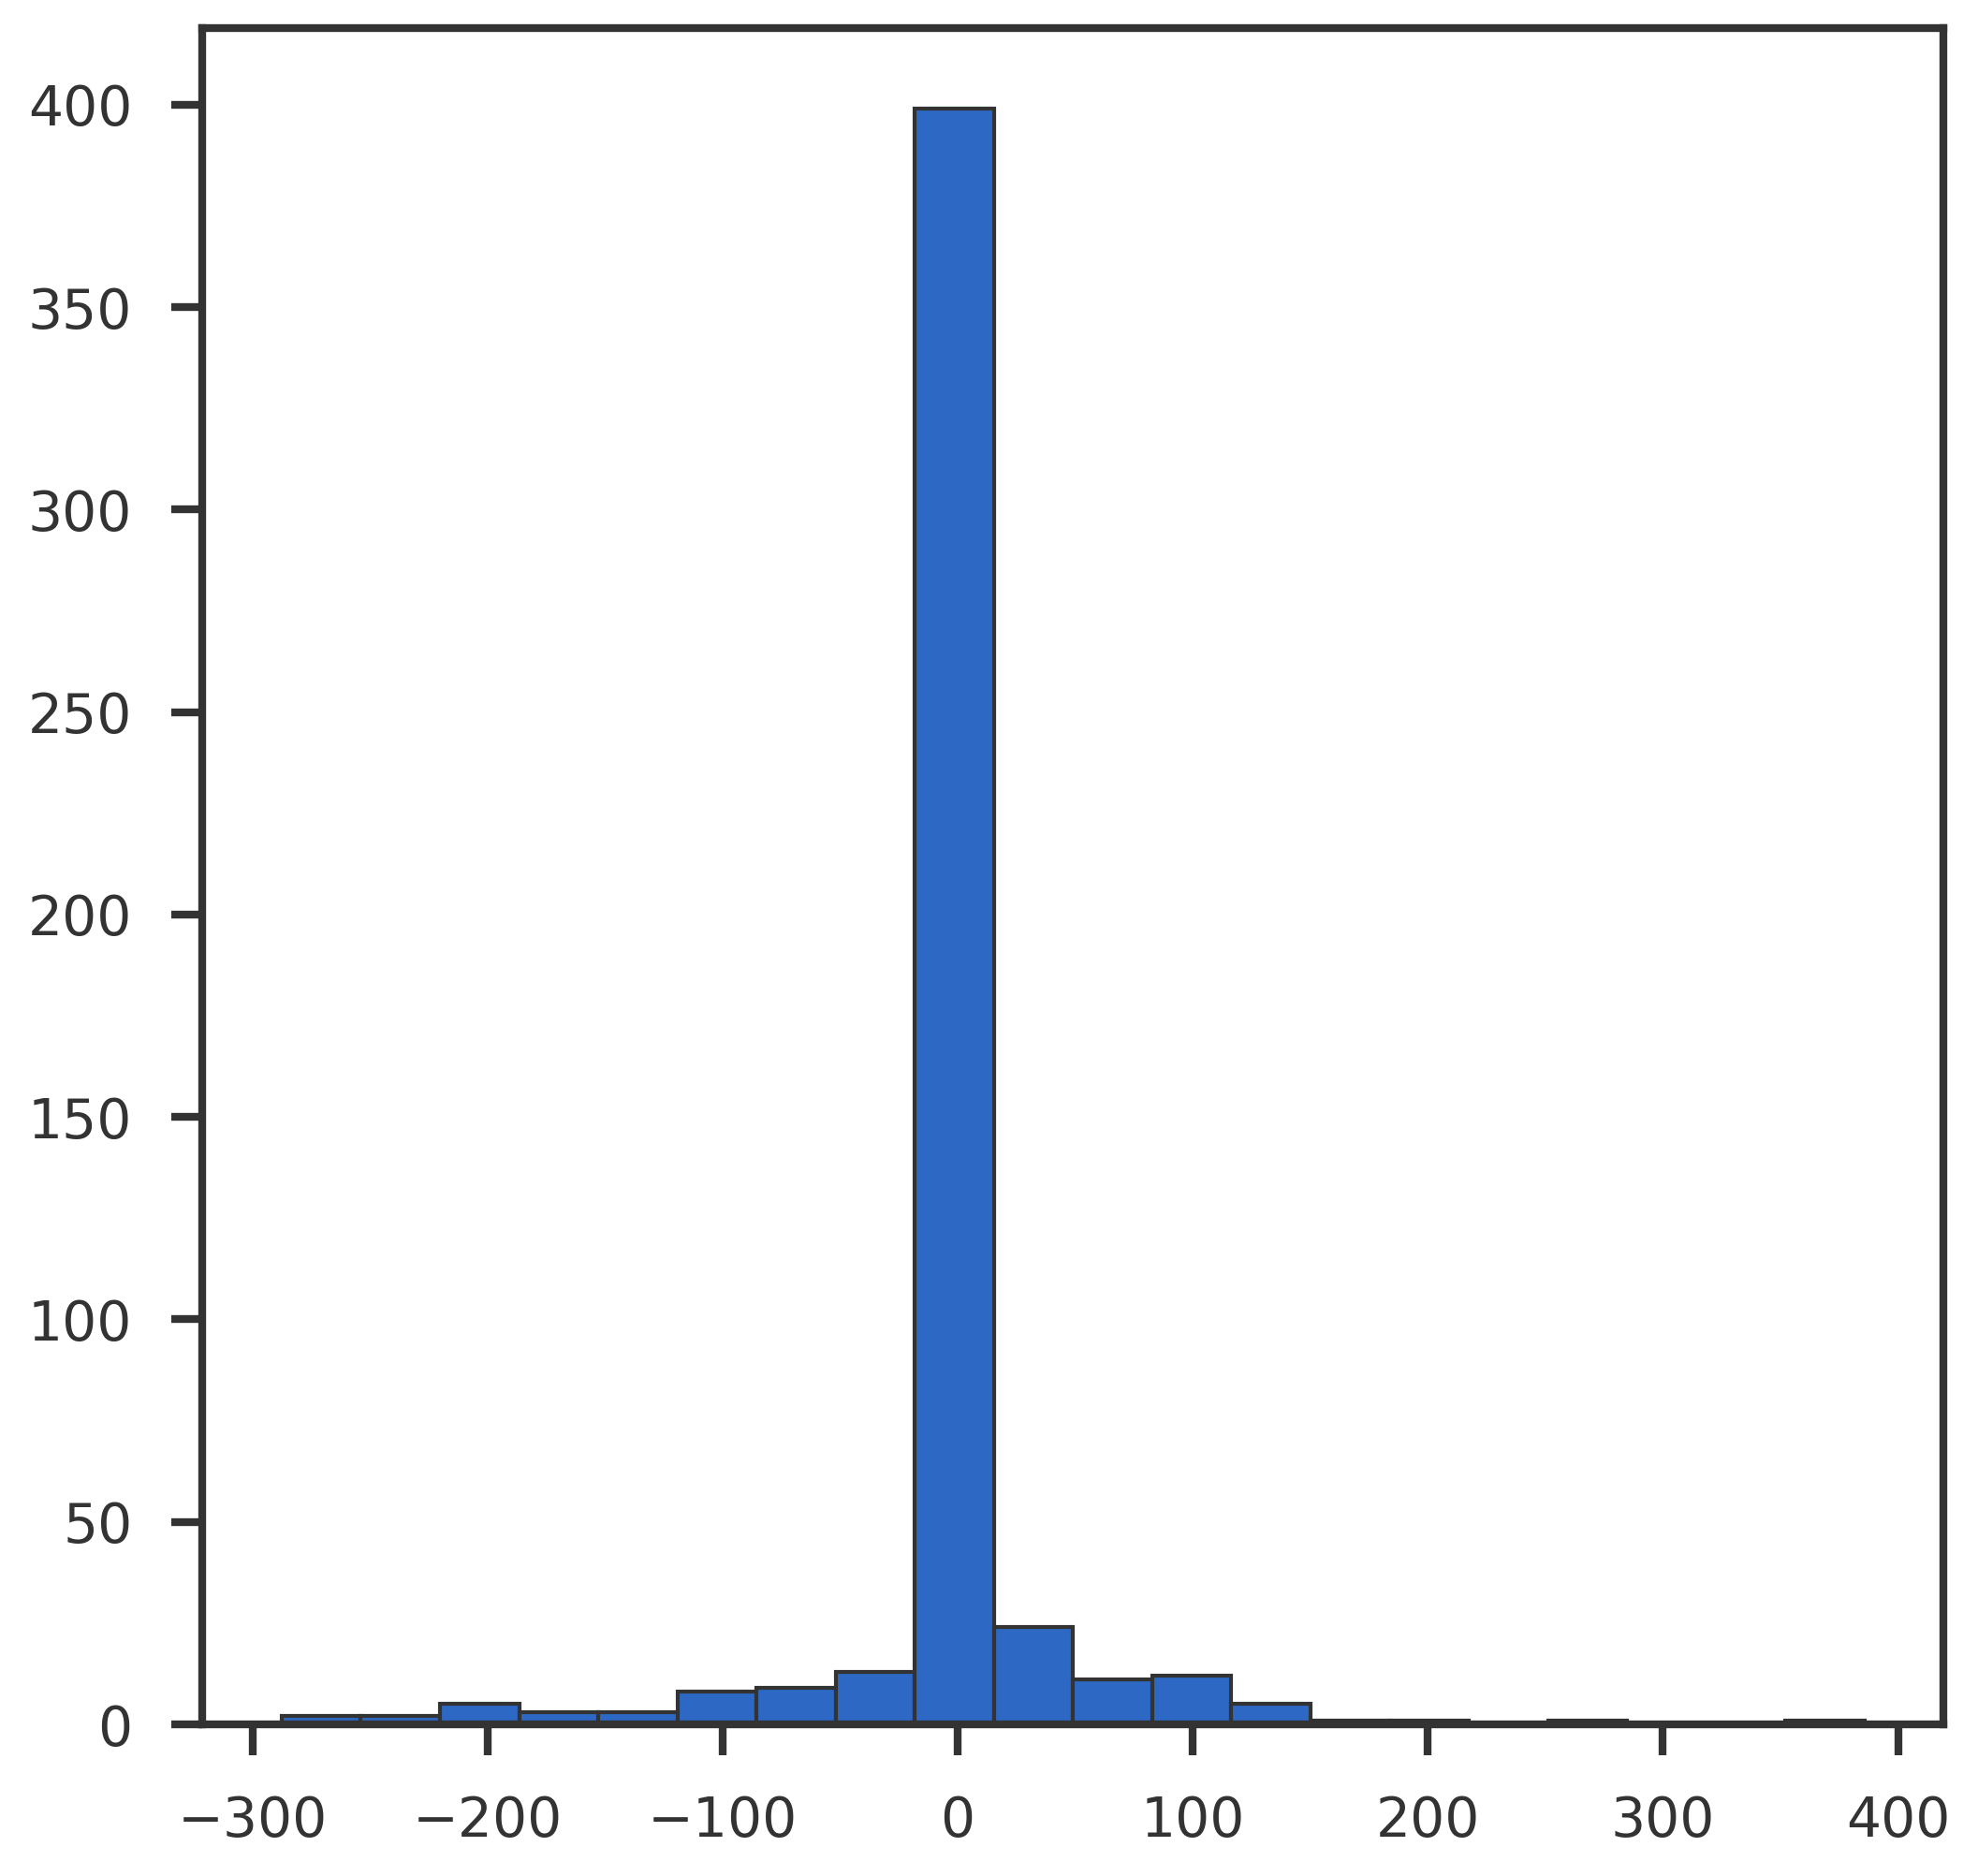

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(btrue)
#ax1.hist(mean)
plt.show()

In [6]:
def softmax(x, base = np.exp(1)):
    if base is not None:
        beta = np.log(base)
        x = x * beta
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis = 0, keepdims = True)

def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

def penalty_operator_lagrangian(z, wk, std, sk, dj, lgrng, b):
    Mt  = shrink_theta(z, std, wk, sk, dj)
    hwt = penalty_operator(z, wk, std, sk, dj)
    obj = np.sum(hwt) + np.sum(lgrng * (Mt - b))
    return obj

def penalty_operator_lagrangian_deriv(z, wk, std, sk, dj, lgrng, b):
    '''
    The Normal Means model
    '''
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    '''
    gradient w.r.t lambda_j (lagrangian penalty)
    '''
    M, M_bgrad, M_wgrad, M_s2grad  = shrinkage_operator(nmash)
    dLdl = M - b
    '''
    gradient w.r.t wk (prior mixture coefficients)
    '''
    tvar  = (strue * strue) / dj
    v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
    ## gradient of first term and second term of the lagrangian
    l1_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
    l2_wgrad = lgrng.reshape(-1, 1) * M_wgrad
    dLdw = np.sum(l1_wgrad + l2_wgrad, axis = 0)
    '''
    gradient w.r.t theta
    '''
    l1_tgrad = - nmash.logML_deriv  - tvar * nmash.logML_deriv * nmash.logML_deriv2
    l2_tgrad = lgrng * (1 + tvar * nmash.logML_deriv2)
    dLdt = l1_tgrad + l2_tgrad
    return dLdl, dLdw, dLdt

def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, strue, sk, dj, lj, btrue)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

748.1862973358625
4203.277954867171
1655.2902083317954
1775.7582978442942
1711.1259679743866
1709.997646920945
1709.8544395794902


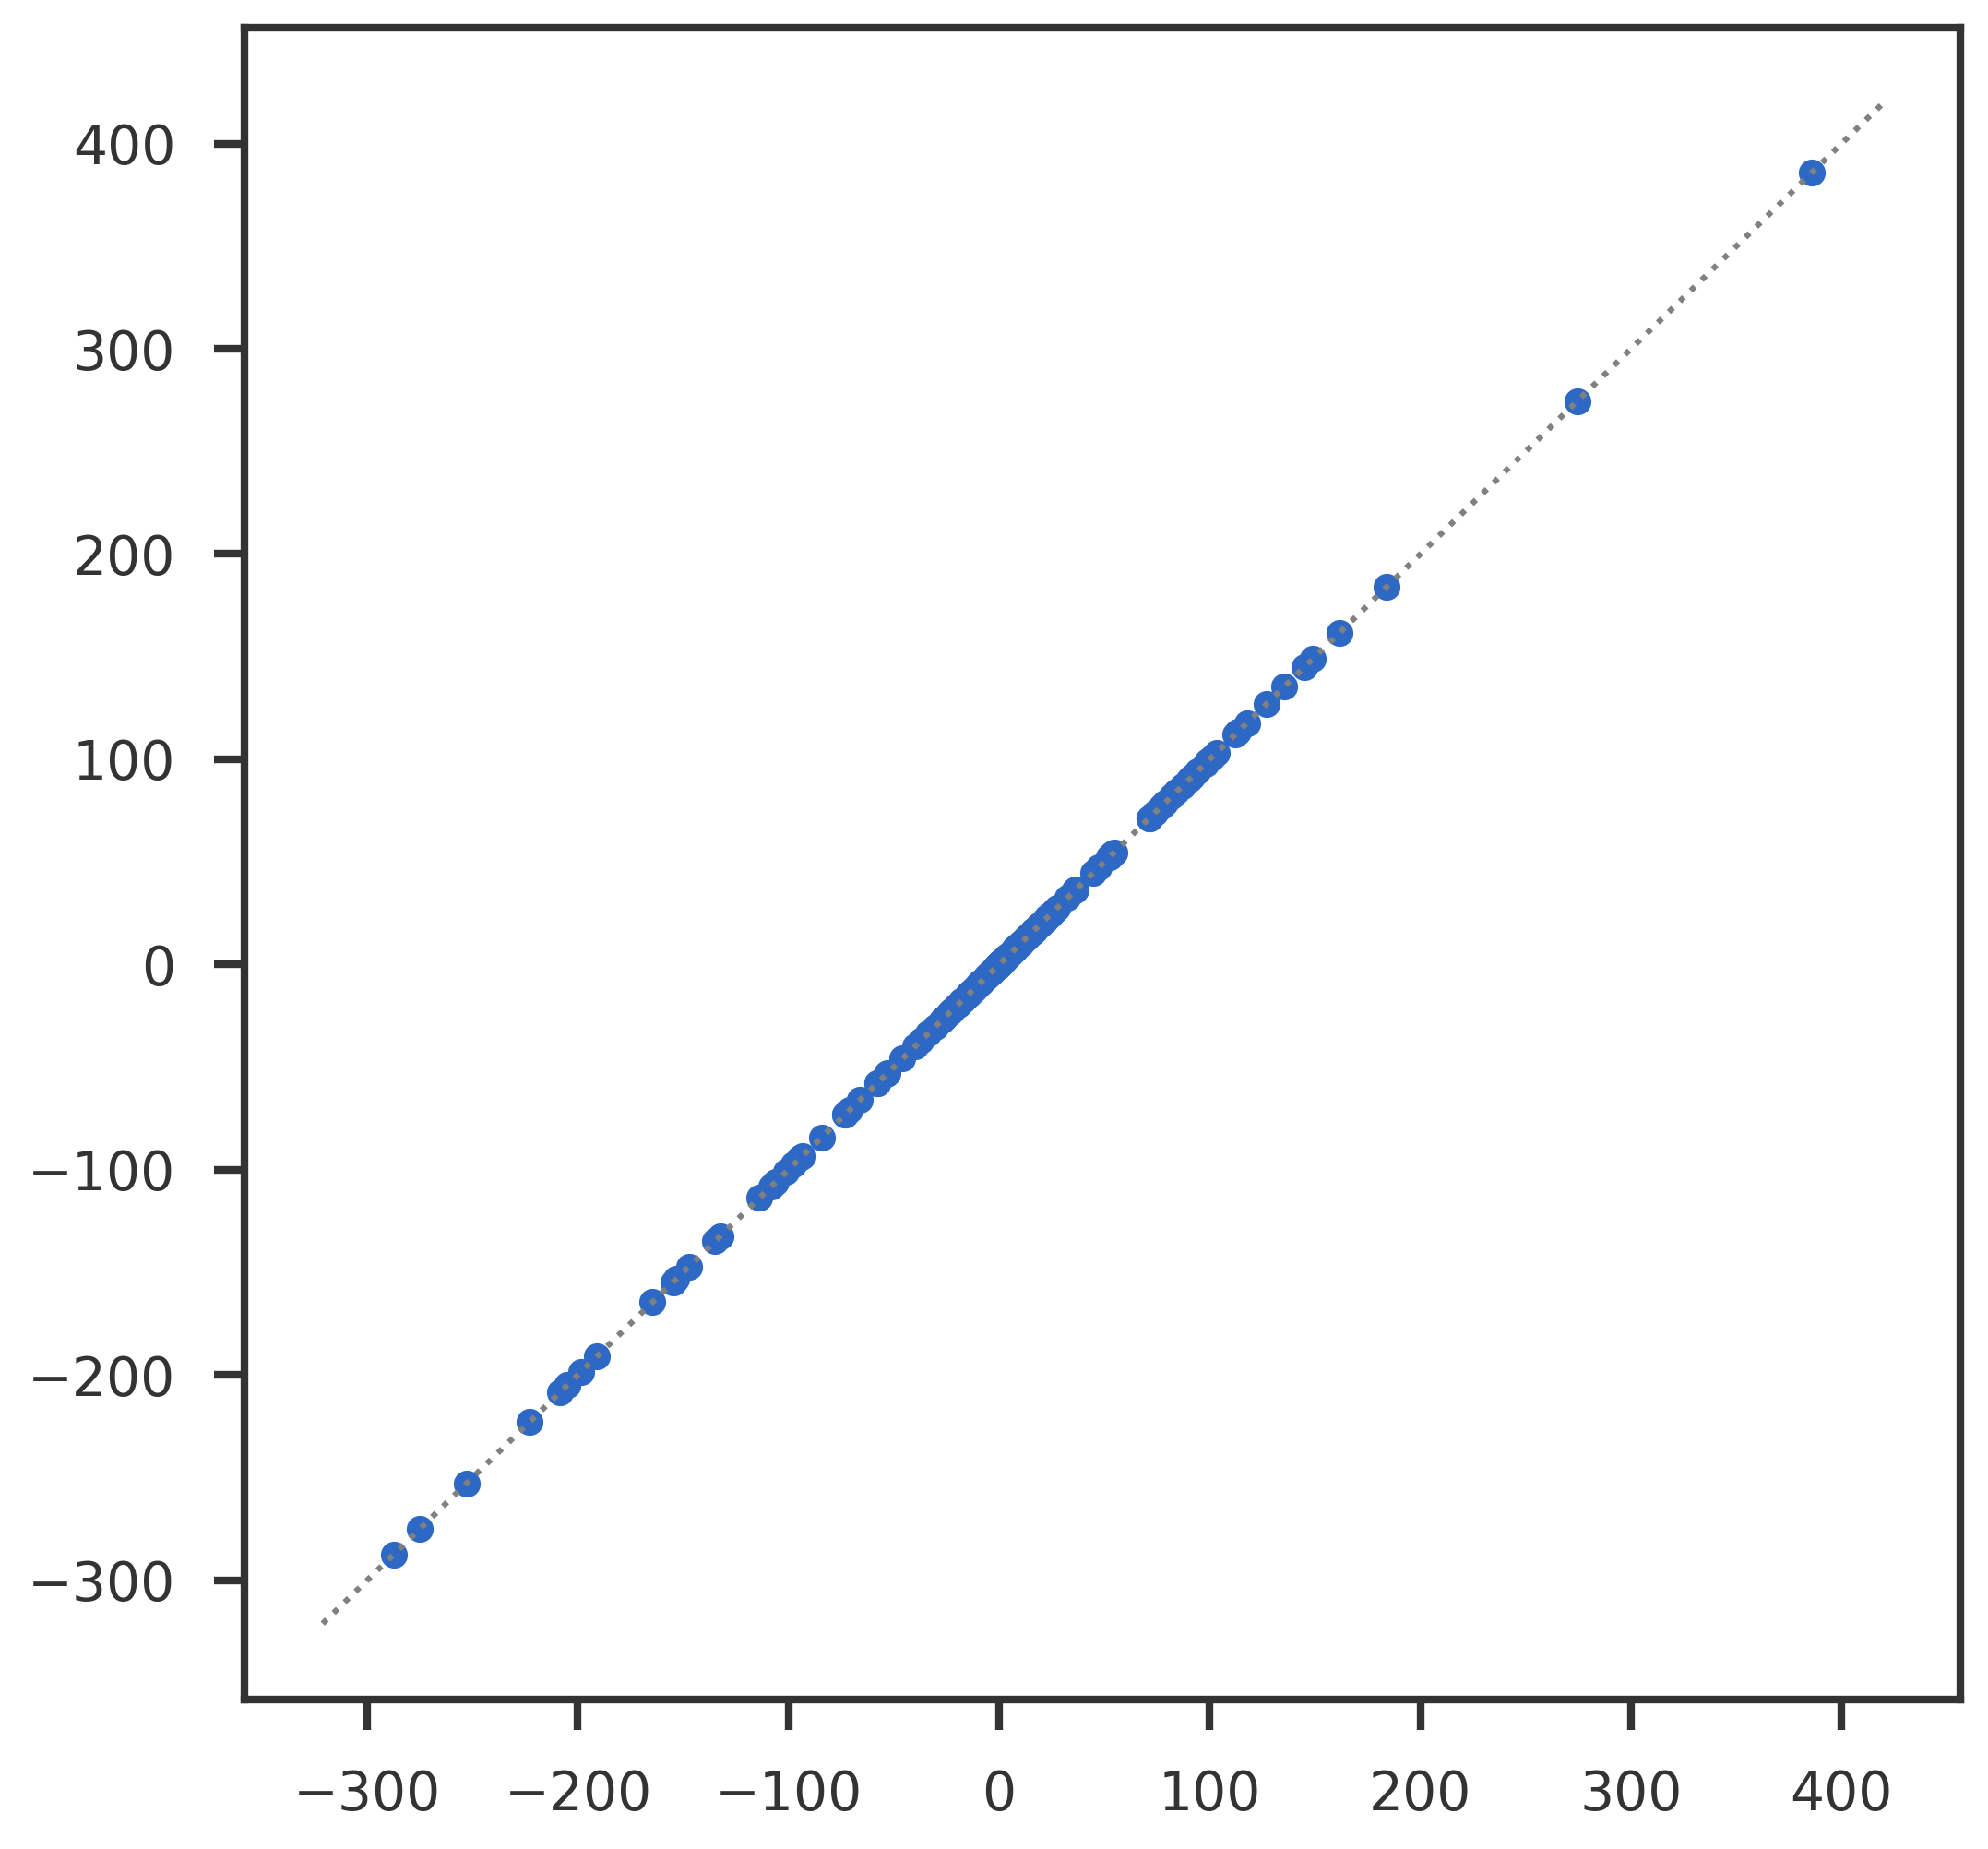

In [7]:
z_newraph = unshrink_b(btrue, strue, wtrue, sk, dj)
b_newraph = shrink_theta(z_newraph, strue, wtrue, sk, dj)
objtrue   = penalty_operator(z_newraph, wtrue, strue, sk, dj)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, b_newraph)
mpl_utils.plot_diag(ax1)

In [8]:
z = np.random.rand(p)
softmax_base = np.exp(1)
winit, _ = initialize_ash_prior(k)
akinit = np.log(winit + 1e-8) / np.log(softmax_base)
s2init = strue * strue

In [9]:
'''
Use mr.ash.pen for the penalty function
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
                debug = False, display_progress = False, calculate_elbo = False, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(np.eye(p), btrue, sk, binit = btrue, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 85.


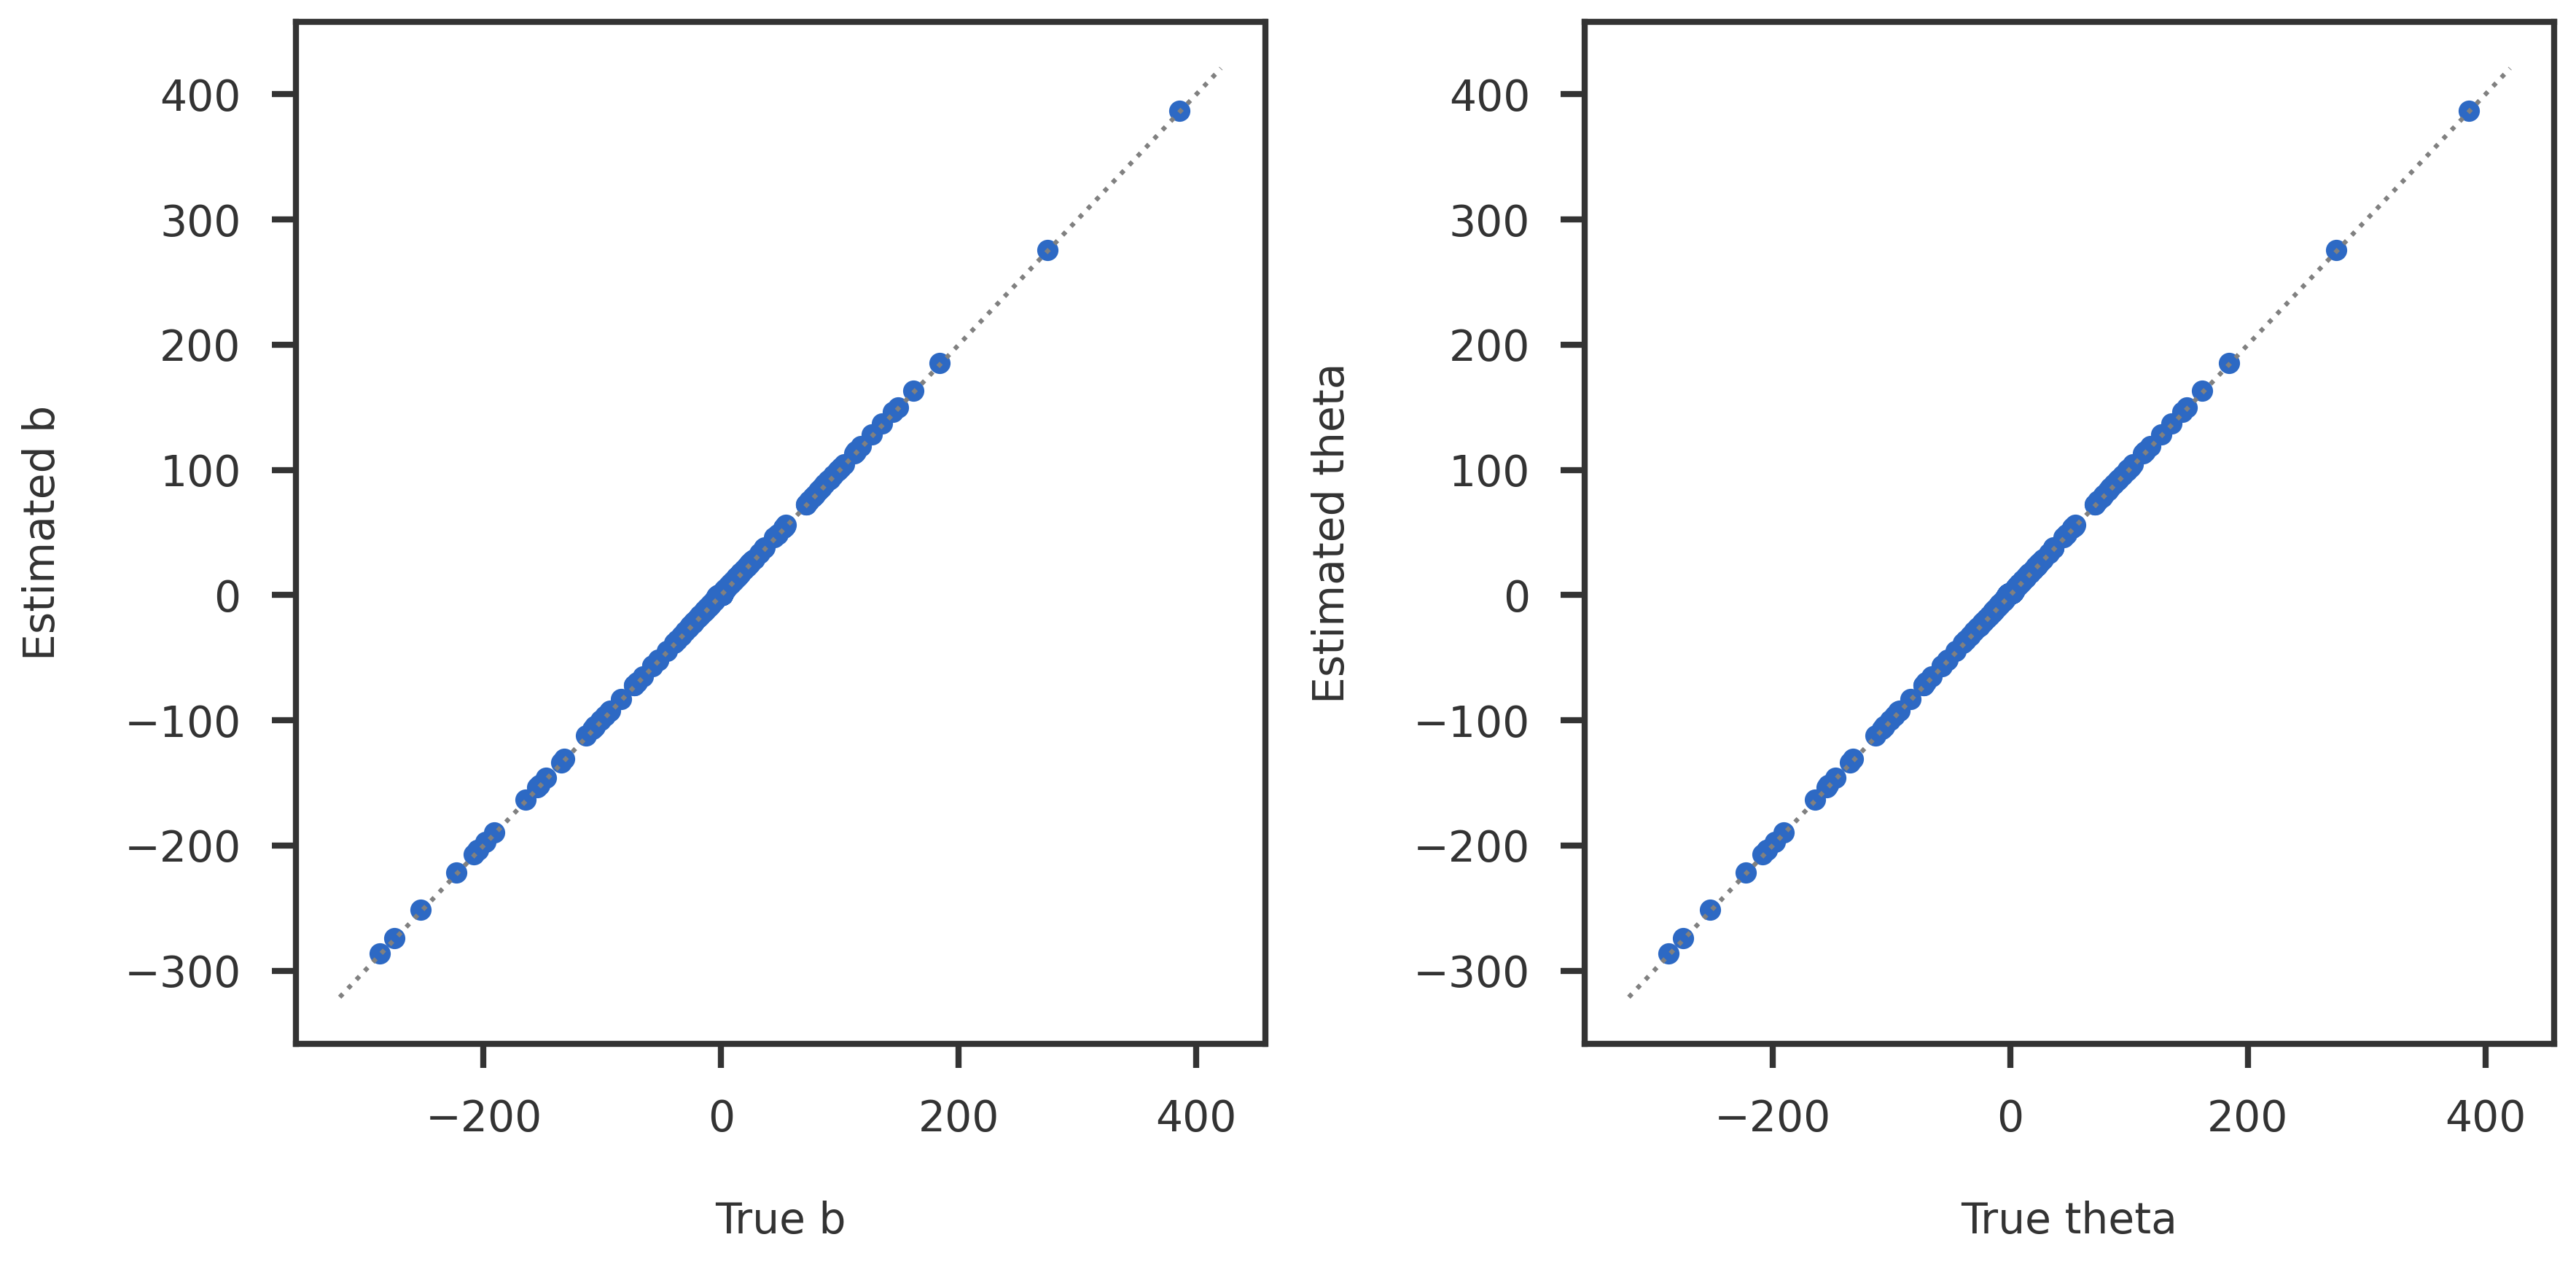

In [10]:
b_hat = plr_lbfgs.coef
z_hat = plr_lbfgs.theta

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(btrue, b_hat)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("True b")
ax1.set_ylabel("Estimated b")

ax2.scatter(z_newraph, z_hat)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True theta")
ax2.set_ylabel("Estimated theta")

plt.tight_layout()

plt.show()

In [11]:
plr_lbfgs.prior

array([5.87024531e-01, 3.08440583e-07, 2.11336765e-01, 2.01638395e-01])

In [12]:
winit

array([0.25, 0.25, 0.25, 0.25])

In [13]:
wtrue

array([0.4, 0.2, 0.2, 0.2])

In [14]:
plr_lbfgs.prior[0]

0.5870245310359506